In [1]:
import os
import sys
import numpy as np
from scipy import signal
import pickle
import time
import neuron
from neuron import h
from neuron import gui
import matplotlib.pyplot as plt
import random
plt.rcParams.update({'font.size': 15})

--No graphics will be displayed.


In [2]:
!nrnivmodl mods

/home/mjy/anaconda3/envs/bilinear_network/bin/nrnivmodl:10: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import working_set
/home/mjy/project/bilinear_network/2021Neuron/L5PC
Mod files: "mods/mods/CaDynamics_E2.mod" "mods/mods/Ca_HVA.mod" "mods/mods/Ca_LVAst.mod" "mods/mods/epsp.mod" "mods/mods/Ih.mod" "mods/mods/Im.mod" "mods/mods/K_Pst.mod" "mods/mods/K_Tst.mod" "mods/mods/kv.mod" "mods/mods/na.mod" "mods/mods/Nap_Et2.mod" "mods/mods/NaTa_t.mod" "mods/mods/NaTs2_t.mod" "mods/mods/ProbAMPA.mod" "mods/mods/ProbAMPANMDA2_ratio.mod" "mods/mods/ProbAMPANMDA_EMS.mod" "mods/mods/ProbAMPANMDA.mod" "mods/mods/ProbGABAAB_EMS.mod" "mods/mods/ProbGABAA_EMS.mod" "mods/mods/ProbGABAA.mod" "mods/mods/ProbNMDA.mod" "mods/mods/SK_E2.mod" "mods/mods/SKv3_1.mod"

 -> Compiling mod_func.cpp
 => LINKING shared library ./libnrnmech.so
Successfully created x86_64/special


In [3]:
# get or randomly generate random seed
random = True
if random == False:
    randomSeed = int(72650)
    print('random seed selected by user - %d' %(randomSeed))
else:
    randomSeed = np.random.randint(100000)
    print('randomly choose seed - %d' %(randomSeed))
np.random.seed(randomSeed)

#%% define simulation params

# general simulation parameters
numSimulations = 1
totalSimDurationInSec = 1
collectAndSaveDVTs = False
# # synapse type
# excitatorySynapseType = 'NMDA'    # supported options: {'AMPA','NMDA','mixed'}
# excitatorySynapseType = 'AMPA'    # supported options: {'AMPA','NMDA','mixed'}
excitatorySynapseType = 'AMPA'    # supported options: {'AMPA','NMDA','mixed'}
inhibitorySynapseType = 'GABA_A'

# use active dendritic conductances switch
useActiveDendrites = True

# attenuation factor for the conductance of the SK channel
SKE2_mult_factor = 1.0

# determine the voltage activation curve of the Ih current (HCN channel)
Ih_vshift = 0

# simulation duration
sim_duration_sec = totalSimDurationInSec
sim_duration_ms  = 1000 * sim_duration_sec

# define inst rate between change interval and smoothing sigma options
# inst_rate_sampling_time_interval_options_ms   = [25,30,35,40,45,55,60,65,70,75,80,85,90,100,150,200,300,450]
# temporal_inst_rate_smoothing_sigma_options_ms = [25,30,35,40,50,60,80,100,150,200,300,400,500,600]

inst_rate_sampling_time_interval_options_ms   = [25,30,35,40,45,55,60,65,70,75,80,85,90,100]
temporal_inst_rate_smoothing_sigma_options_ms = [25,30,35,40,50,60,80,100]

inst_rate_sampling_time_interval_jitter_range   = 20
temporal_inst_rate_smoothing_sigma_jitter_range = 20

# number of spike ranges for the simulation

# AMPA with attenuated SK_E2 conductance
#num_bas_ex_spikes_per_100ms_range = [0,1900]
#num_bas_ex_inh_spike_diff_per_100ms_range = [-1500,300]
#num_apic_ex_spikes_per_100ms_range = [0,2000]
#num_apic_ex_inh_spike_diff_per_100ms_range = [-1500,300]

# AMPA
num_bas_ex_spikes_per_100ms_range = [0,1900]
num_bas_ex_inh_spike_diff_per_100ms_range = [-1650,150]
num_apic_ex_spikes_per_100ms_range = [0,2000]
num_apic_ex_inh_spike_diff_per_100ms_range = [-1650,150]

# NMDA
num_bas_ex_spikes_per_100ms_range = [0,800]
num_bas_ex_inh_spike_diff_per_100ms_range = [-600,200]
num_apic_ex_spikes_per_100ms_range = [0,800]
num_apic_ex_inh_spike_diff_per_100ms_range = [-600,200]

# "regularization" param for the segment lengths (mainly used to not divide by very small numbers)
min_seg_length_um = 10.0

# beaurrocracy
showPlots = False
resultsSavedIn_rootFolder = 'output/'

useCvode = True
totalSimDurationInMS = 1000 * totalSimDurationInSec

#%% define some helper functions


def generate_input_spike_trains_for_simulation(sim_duration_ms, basal_seg_length_um, apical_seg_length_um, min_seg_length_um,
                                               num_bas_ex_spikes_per_100ms_range, num_apic_ex_spikes_per_100ms_range,
                                               num_bas_ex_inh_spike_diff_per_100ms_range, num_apic_ex_inh_spike_diff_per_100ms_range,
                                               inst_rate_sampling_time_interval_options_ms, temporal_inst_rate_smoothing_sigma_options_ms):
    
    # extract the number of basal and apical segments
    num_basal_segments  = len(basal_seg_length_um)
    num_apical_segments = len(apical_seg_length_um)
        
    # adjust segment lengths (with "min_seg_length_um")
    adjusted_basal_length_um  = min_seg_length_um + basal_seg_length_um
    adjusted_apical_length_um = min_seg_length_um + apical_seg_length_um
    
    # calc sum of seg length (to be used for normalization later on)
    total_adjusted_basal_tree_length_um  = adjusted_basal_length_um.sum()
    total_adjusted_apical_tree_length_um = adjusted_apical_length_um.sum()
    
    # randomly sample inst rate (with some uniform noise) smoothing sigma
    keep_inst_rate_const_for_ms = inst_rate_sampling_time_interval_options_ms[np.random.randint(len(inst_rate_sampling_time_interval_options_ms))]
    keep_inst_rate_const_for_ms += int(2 * inst_rate_sampling_time_interval_jitter_range * np.random.rand() - inst_rate_sampling_time_interval_jitter_range)
    
    # randomly sample smoothing sigma (with some uniform noise)
    temporal_inst_rate_smoothing_sigma = temporal_inst_rate_smoothing_sigma_options_ms[np.random.randint(len(temporal_inst_rate_smoothing_sigma_options_ms))]
    temporal_inst_rate_smoothing_sigma += int(2 * temporal_inst_rate_smoothing_sigma_jitter_range * np.random.rand() - temporal_inst_rate_smoothing_sigma_jitter_range)
    
    num_inst_rate_samples = int(np.ceil(float(sim_duration_ms) / keep_inst_rate_const_for_ms))
    
    # create the coarse inst rates with units of "total spikes per tree per 100 ms"
    num_bas_ex_spikes_per_100ms   = np.random.uniform(low=num_bas_ex_spikes_per_100ms_range[0], high=num_bas_ex_spikes_per_100ms_range[1], size=(1,num_inst_rate_samples))
    num_bas_inh_spikes_low_range  = np.maximum(0, num_bas_ex_spikes_per_100ms + num_bas_ex_inh_spike_diff_per_100ms_range[0])
    num_bas_inh_spikes_high_range = num_bas_ex_spikes_per_100ms + num_bas_ex_inh_spike_diff_per_100ms_range[1]
    num_bas_inh_spikes_per_100ms  = np.random.uniform(low=num_bas_inh_spikes_low_range, high=num_bas_inh_spikes_high_range, size=(1,num_inst_rate_samples))
    
    num_apic_ex_spikes_per_100ms   = np.random.uniform(low=num_apic_ex_spikes_per_100ms_range[0], high=num_apic_ex_spikes_per_100ms_range[1],size=(1,num_inst_rate_samples))
    num_apic_inh_spikes_low_range  = np.maximum(0, num_apic_ex_spikes_per_100ms + num_apic_ex_inh_spike_diff_per_100ms_range[0])
    num_apic_inh_spikes_high_range = num_apic_ex_spikes_per_100ms + num_apic_ex_inh_spike_diff_per_100ms_range[1]
    num_apic_inh_spikes_per_100ms  = np.random.uniform(low=num_apic_inh_spikes_low_range, high=num_apic_inh_spikes_high_range, size=(1,num_inst_rate_samples))
    
    # convert to units of "per_1um_per_1ms"
    ex_bas_spike_rate_per_1um_per_1ms   = num_bas_ex_spikes_per_100ms   / (total_adjusted_basal_tree_length_um  * 100.0)
    inh_bas_spike_rate_per_1um_per_1ms  = num_bas_inh_spikes_per_100ms  / (total_adjusted_basal_tree_length_um  * 100.0)
    ex_apic_spike_rate_per_1um_per_1ms  = num_apic_ex_spikes_per_100ms  / (total_adjusted_apical_tree_length_um * 100.0)
    inh_apic_spike_rate_per_1um_per_1ms = num_apic_inh_spikes_per_100ms / (total_adjusted_apical_tree_length_um * 100.0)
            
    # kron by space (uniform distribution across branches per tree)
    ex_bas_spike_rate_per_seg_per_1ms   = np.kron(ex_bas_spike_rate_per_1um_per_1ms  , np.ones((num_basal_segments,1)))
    inh_bas_spike_rate_per_seg_per_1ms  = np.kron(inh_bas_spike_rate_per_1um_per_1ms , np.ones((num_basal_segments,1)))
    ex_apic_spike_rate_per_seg_per_1ms  = np.kron(ex_apic_spike_rate_per_1um_per_1ms , np.ones((num_apical_segments,1)))
    inh_apic_spike_rate_per_seg_per_1ms = np.kron(inh_apic_spike_rate_per_1um_per_1ms, np.ones((num_apical_segments,1)))
        
    # vstack basal and apical
    ex_spike_rate_per_seg_per_1ms  = np.vstack((ex_bas_spike_rate_per_seg_per_1ms , ex_apic_spike_rate_per_seg_per_1ms))
    inh_spike_rate_per_seg_per_1ms = np.vstack((inh_bas_spike_rate_per_seg_per_1ms, inh_apic_spike_rate_per_seg_per_1ms))
    
    # add some spatial multiplicative randomness (that will be added to the sampling noise)
    ex_spike_rate_per_seg_per_1ms  = np.random.uniform(low=0.5, high=1.5, size=ex_spike_rate_per_seg_per_1ms.shape ) * ex_spike_rate_per_seg_per_1ms
    inh_spike_rate_per_seg_per_1ms = np.random.uniform(low=0.5, high=1.5, size=inh_spike_rate_per_seg_per_1ms.shape) * inh_spike_rate_per_seg_per_1ms
    
    # concatenate the adjusted length
    adjusted_length_um = np.hstack((adjusted_basal_length_um, adjusted_apical_length_um))
    
    # multiply each segment by it's length (now every segment will have firing rate proportional to it's length)
    ex_spike_rate_per_seg_per_1ms  = ex_spike_rate_per_seg_per_1ms  * np.tile(adjusted_length_um[:,np.newaxis], [1, ex_spike_rate_per_seg_per_1ms.shape[1]])
    inh_spike_rate_per_seg_per_1ms = inh_spike_rate_per_seg_per_1ms * np.tile(adjusted_length_um[:,np.newaxis], [1, inh_spike_rate_per_seg_per_1ms.shape[1]])
        
    # kron by time (crop if there are leftovers in the end) to fill up the time to 1ms time bins
    ex_spike_rate_per_seg_per_1ms  = np.kron(ex_spike_rate_per_seg_per_1ms , np.ones((1,keep_inst_rate_const_for_ms)))[:,:sim_duration_ms]
    inh_spike_rate_per_seg_per_1ms = np.kron(inh_spike_rate_per_seg_per_1ms, np.ones((1,keep_inst_rate_const_for_ms)))[:,:sim_duration_ms]
    
    # filter the inst rates according to smoothing sigma
    smoothing_window = signal.gaussian(1.0 + 7 * temporal_inst_rate_smoothing_sigma, std=temporal_inst_rate_smoothing_sigma)[np.newaxis,:]
    smoothing_window /= smoothing_window.sum()
    seg_inst_rate_ex_smoothed  = signal.convolve(ex_spike_rate_per_seg_per_1ms,  smoothing_window, mode='same')
    seg_inst_rate_inh_smoothed = signal.convolve(inh_spike_rate_per_seg_per_1ms, smoothing_window, mode='same')
    
    # sample the instantanous spike prob and then sample the actual spikes
    ex_inst_spike_prob = np.random.exponential(scale=seg_inst_rate_ex_smoothed)
    ex_spikes_bin      = np.random.rand(ex_inst_spike_prob.shape[0], ex_inst_spike_prob.shape[1]) < ex_inst_spike_prob
    
    inh_inst_spike_prob = np.random.exponential(scale=seg_inst_rate_inh_smoothed)
    inh_spikes_bin      = np.random.rand(inh_inst_spike_prob.shape[0], inh_inst_spike_prob.shape[1]) < inh_inst_spike_prob
    
    return ex_spikes_bin, inh_spikes_bin

def GetDirNameAndFileName(numOutputSpikes, randomSeed):
    # string to describe model name based on params

    cellType = 'L5PC'
    synapseTypes    = excitatorySynapseType + '_' + inhibitorySynapseType
    dendritesKind = 'activeDendrites'
    if not useActiveDendrites:
        dendritesKind = 'passiveDendrites'
    else:
        dendritesKind += '_Ih_vshift_%d_SKE2_mult_%d' %(Ih_vshift, 100 * SKE2_mult_factor)
        
    modelString = cellType + '__' + dendritesKind + '__' + synapseTypes
    dirToSaveIn = resultsSavedIn_rootFolder + modelString + '//'
    
    # string to describe input
    string1 = 'exBas_%d_%d_inhBasDiff_%d_%d' %(num_bas_ex_spikes_per_100ms_range[0],num_bas_ex_spikes_per_100ms_range[1],
                                               num_bas_ex_inh_spike_diff_per_100ms_range[0],num_bas_ex_inh_spike_diff_per_100ms_range[1])
    string2 = 'exApic_%d_%d_inhApicDiff_%d_%d' %(num_apic_ex_spikes_per_100ms_range[0],num_apic_ex_spikes_per_100ms_range[1],
                                                 num_apic_ex_inh_spike_diff_per_100ms_range[0],num_apic_ex_inh_spike_diff_per_100ms_range[1])
    inputString = string1 + '__' + string2
    
    # string to describe simulation
    savedDVTs = ''
    if collectAndSaveDVTs:
        savedDVTs = 'DVTs'
    
    string3 = 'saved_InputSpikes_%s__%d_outSpikes__%d_simulationRuns__%d_secDuration__randomSeed_%d'
    simulationString = string3 %(savedDVTs, numOutputSpikes, numSimulations,totalSimDurationInSec, randomSeed)
                  
    filenameToSave = inputString + '__' + simulationString + '.p'
                 
    return dirToSaveIn, filenameToSave


def GetDistanceBetweenSections(sourceSection, destSection):
    h.distance(sec=sourceSection)
    return h.distance(0, sec=destSection)

# AMPA synapse
def DefineSynapse_AMPA(segment, gMax=0.00015*5): # gMax=0.0004
    # synapse = h.ProbUDFsyn2(segment)
    synapse = h.ProbAMPA(segment)

    synapse.tau_r = 0.3
    synapse.tau_d = 3.0
    synapse.gmax = gMax
    synapse.e = 0
    synapse.Use = 1
    synapse.u0 = 0
    synapse.Dep = 0
    synapse.Fac = 0

    return synapse


# NMDA synapse
# def DefineSynapse_NMDA(segment, gMax_AMPA=0.00009, gMax_NMDA=0.00009*0.3):
#     # synapse = h.ProbAMPANMDA2(segment)
#     synapse = h.ProbAMPANMDA(segment)

#     synapse.tau_r_AMPA = 0.3
#     synapse.tau_d_AMPA = 3.0
#     synapse.tau_r_NMDA = 2.0
#     synapse.tau_d_NMDA = 70.0

#     # synapse.gmax = gMax
#     synapse.gmax_AMPA = gMax_AMPA
#     synapse.gmax_NMDA = gMax_NMDA
#     synapse.e = 0
#     synapse.Use = 1
#     synapse.u0 = 0
#     synapse.Dep = 0
#     synapse.Fac = 0

#     return synapse
def DefineSynapse_NMDA(segment, gMax=0.00015*3):
    # synapse = h.ProbAMPANMDA2(segment)
    # synapse = h.ProbAMPANMDA(segment)
    synapse = h.ProbNMDA(segment)

    synapse.tau_r = 2.0
    synapse.tau_d = 70.0

    synapse.gmax = gMax

    synapse.e = 0
    synapse.Use = 1
    synapse.u0 = 0
    synapse.Dep = 0
    synapse.Fac = 0

    return synapse


# GABA A synapse
def DefineSynapse_GABA_A(segment, gMax=0.001):
    synapse = h.ProbGABAA(segment)

    synapse.tau_r = 0.2
    synapse.tau_d = 8
    synapse.gmax = gMax
    synapse.e = -80
    synapse.Use = 1
    synapse.u0 = 0
    synapse.Dep = 0
    synapse.Fac = 0

    return synapse


# GABA B synapse
def DefineSynapse_GABA_B(segment, gMax=0.001):
    synapse = h.ProbUDFsyn2(segment)

    synapse.tau_r = 3.5
    synapse.tau_d = 260.9
    synapse.gmax = gMax
    synapse.e = -97
    synapse.Use = 1
    synapse.u0 = 0
    synapse.Dep = 0
    synapse.Fac = 0

    return synapse


# GABA A+B synapse
def DefineSynapse_GABA_AB(segment, gMax=0.001):
    synapse = h.ProbGABAAB_EMS(segment)

    synapse.tau_r_GABAA = 0.2
    synapse.tau_d_GABAA = 8
    synapse.tau_r_GABAB = 3.5
    synapse.tau_d_GABAB = 260.9
    synapse.gmax = gMax
    synapse.e_GABAA = -80
    synapse.e_GABAB = -97
    synapse.GABAB_ratio = 0.0
    synapse.Use = 1
    synapse.u0 = 0
    synapse.Dep = 0
    synapse.Fac = 0

    return synapse


def ConnectEmptyEventGenerator(synapse):

    netConnection = h.NetCon(None,synapse)
    netConnection.delay = 0
    netConnection.weight[0] = 1

    return netConnection


# create a single image of both excitatory and inhibitory spikes and the dendritic voltage traces
def CreateCombinedColorImage(dendriticVoltageTraces, excitatoryInputSpikes, inhibitoryInputSpikes):
    minV = -85
    maxV = 35
    
    excitatoryInputSpikes = signal.fftconvolve(excitatoryInputSpikes, np.ones((3,3)), mode='same')
    inhibitoryInputSpikes = signal.fftconvolve(inhibitoryInputSpikes, np.ones((3,3)), mode='same')
    
    stimulationImage = np.zeros((np.shape(excitatoryInputSpikes)[0],np.shape(excitatoryInputSpikes)[1],3))
    stimulationImage[:,:,0] = 0.98 * (dendriticVoltageTraces - minV) / (maxV - minV) + inhibitoryInputSpikes
    stimulationImage[:,:,1] = 0.98 * (dendriticVoltageTraces - minV) / (maxV - minV) + excitatoryInputSpikes
    stimulationImage[:,:,2] = 0.98 * (dendriticVoltageTraces - minV) / (maxV - minV)
    stimulationImage[stimulationImage > 1] = 1

    return stimulationImage


randomly choose seed - 12600


In [4]:
# h.load_file('nrngui.hoc')
h.load_file("import3d.hoc")

morphologyFilename = "morphologies/cell1.asc"
biophysicalModelFilename = "L5PCbiophys5b.hoc"
biophysicalModelTemplateFilename = "L5PCtemplate_2.hoc"

h.load_file(biophysicalModelFilename)
h.load_file(biophysicalModelTemplateFilename)
L5PC = h.L5PCtemplate(morphologyFilename)

845.34678 
845.34678 


In [5]:
all_sections = [sec for sec in h.allsec()]

# New list with only 'dend1' and 'dend2'
selected_sections = [sec for sec in all_sections if 'dend' in sec.name()]

seg_list = [seg for sec in selected_sections for seg in sec]

In [6]:
import random
indices = random.sample(range(262), 50)
selected_seg = [seg_list[i] for i in indices]

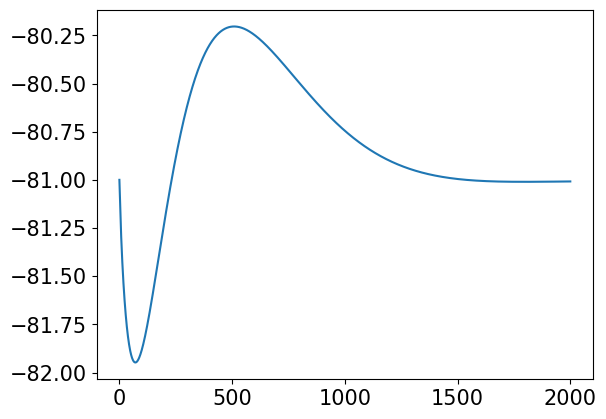

In [7]:
h.dt = 0.1
ns0 = h.NetStim()
ns1 = h.NetStim()

syn0 = h.ExpSyn(selected_seg[-30])
syn1 = h.ExpSyn(selected_seg[1])

nc0 = h.NetCon(ns0, syn0)
nc1 = h.NetCon(ns1, syn1)

ns0.start = ns1.start = 0
ns0.number = ns1.number = 1
ns0.interval = ns1.interval = 50
ns0.noise = ns1.noise = 0
nc0.delay = nc1.delay = 000

syn0.tau = syn1.tau = 7
syn0.e = syn1.e = -100
nc0.weight[0] = 0.003
nc1.weight[0] = 0.000
t = h.Vector().record(h._ref_t)
v = h.Vector().record(L5PC.soma[0](0.5)._ref_v)
h.finitialize(-81)
h.continuerun(200)
plt.plot(v)

In [8]:
h.dt = 0.1
N = len(selected_seg)
# active
print('active begin')
print('--------------------------------------------------')
print('EE begin')
KEE = np.zeros(int(N*(N-1)/2))

for i in range(N):
    for j in range(i):
        ns0 = h.NetStim()
        ns1 = h.NetStim()

        syn0 = h.ExpSyn(selected_seg[i])
        syn1 = h.ExpSyn(selected_seg[j])

        nc0 = h.NetCon(ns0, syn0)
        nc1 = h.NetCon(ns1, syn1)

        ns0.start = ns1.start = 0
        ns0.number = ns1.number = 1
        ns0.interval = ns1.interval = 50
        ns0.noise = ns1.noise = 0
        nc0.delay = nc1.delay = 000

        syn0.tau = syn1.tau = 7
        syn0.e = syn1.e = 0

        for k in range(3):
            if k == 0:
                nc0.weight[0] = 0.003
                nc1.weight[0] = 0.003
                t = h.Vector().record(h._ref_t)
                v = h.Vector().record(L5PC.soma[0](0.5)._ref_v)
                h.finitialize(-81)
                h.continuerun(200)
                v1 = np.array(v)
            elif k == 1:
                nc0.weight[0] = 0.003
                nc1.weight[0] = 0.000
                t = h.Vector().record(h._ref_t)
                v = h.Vector().record(L5PC.soma[0](0.5)._ref_v)
                h.finitialize(-81)
                h.continuerun(200)
                v2 = np.array(v)
            else:
                nc0.weight[0] = 0.000
                nc1.weight[0] = 0.003
                t = h.Vector().record(h._ref_t)
                v = h.Vector().record(L5PC.soma[0](0.5)._ref_v)
                h.finitialize(-81)
                h.continuerun(200)
                v3 = np.array(v)

        tp = np.argmax(v2)
        kappa = (v2[tp] + v3[tp] - v1[tp] + 81) / ((v2[tp]+81) * (v3[tp]+81))
        KEE[int(i*(i-1)/2+j)] = kappa
    print('finish', i)

# with open('/home/mjy/project/bilinear_network/2021Neuron/L5PC/data/L5PC_active_EE.p', 'wb') as f:
#     pickle.dump(KEE, f)

KEI = np.zeros(int(N*(N-1)))
print('--------------------------------------------------')
print('EI begin')
idx = 0
for i in range(N):
    for j in range(N):
        while i != j:
            ns0 = h.NetStim()
            ns1 = h.NetStim()

            syn0 = h.ExpSyn(selected_seg[i])
            syn1 = h.ExpSyn(selected_seg[j])

            nc0 = h.NetCon(ns0, syn0)
            nc1 = h.NetCon(ns1, syn1)

            ns0.start = ns1.start = 0
            ns0.number = ns1.number = 1
            ns0.interval = ns1.interval = 50
            ns0.noise = ns1.noise = 0
            nc0.delay = nc1.delay = 000

            syn0.tau = syn1.tau = 7
            syn0.e = 0
            syn1.e = -100
            for k in range(3):
                if k == 0:
                    nc0.weight[0] = 0.003
                    nc1.weight[0] = 0.003
                    t = h.Vector().record(h._ref_t)
                    v = h.Vector().record(L5PC.soma[0](0.5)._ref_v)
                    h.finitialize(-81)
                    h.continuerun(200)
                    v1 = np.array(v)
                elif k == 1:
                    nc0.weight[0] = 0.003
                    nc1.weight[0] = 0.000
                    t = h.Vector().record(h._ref_t)
                    v = h.Vector().record(L5PC.soma[0](0.5)._ref_v)
                    h.finitialize(-81)
                    h.continuerun(200)
                    v2 = np.array(v)
                else:
                    nc0.weight[0] = 0.000
                    nc1.weight[0] = 0.003
                    t = h.Vector().record(h._ref_t)
                    v = h.Vector().record(L5PC.soma[0](0.5)._ref_v)
                    h.finitialize(-81)
                    h.continuerun(200)
                    v3 = np.array(v)

            tp = np.argmax(v1)
            kappa = (v2[tp] + v3[tp] - v1[tp] + 81) / ((v2[tp]+81) * (v3[tp]+81))
            KEI[idx] = kappa
            idx += 1
            break
    print('finish', i)

# with open('/home/mjy/project/bilinear_network/2021Neuron/L5PC/data/L5PC_active_EI.p', 'wb') as f:
#     pickle.dump(KEI, f)

KII = np.zeros(int(N*(N-1)/2))

print('--------------------------------------------------')
print('II begin')
for i in range(N):
    for j in range(i):
        ns0 = h.NetStim()
        ns1 = h.NetStim()

        syn0 = h.ExpSyn(selected_seg[i])
        syn1 = h.ExpSyn(selected_seg[j])

        nc0 = h.NetCon(ns0, syn0)
        nc1 = h.NetCon(ns1, syn1)

        ns0.start = ns1.start = 0
        ns0.number = ns1.number = 1
        ns0.interval = ns1.interval = 50
        ns0.noise = ns1.noise = 0
        nc0.delay = nc1.delay = 000

        syn0.tau = syn1.tau = 7
        syn0.e = syn1.e = -100

        for k in range(3):
            if k == 0:
                nc0.weight[0] = 0.003
                nc1.weight[0] = 0.003
                t = h.Vector().record(h._ref_t)
                v = h.Vector().record(L5PC.soma[0](0.5)._ref_v)
                h.finitialize(-81)
                h.continuerun(200)
                v1 = np.array(v)
            elif k == 1:
                nc0.weight[0] = 0.003
                nc1.weight[0] = 0.000
                t = h.Vector().record(h._ref_t)
                v = h.Vector().record(L5PC.soma[0](0.5)._ref_v)
                h.finitialize(-81)
                h.continuerun(200)
                v2 = np.array(v)
            else:
                nc0.weight[0] = 0.000
                nc1.weight[0] = 0.003
                t = h.Vector().record(h._ref_t)
                v = h.Vector().record(L5PC.soma[0](0.5)._ref_v)
                h.finitialize(-81)
                h.continuerun(200)
                v3 = np.array(v)

        tp = np.argmin(v2)
        kappa = (v2[tp] + v3[tp] - v1[tp] + 81) / ((v2[tp]+81) * (v3[tp]+81))
        KII[int(i*(i-1)/2+j)] = kappa
    print('finish', i)

# with open('/home/mjy/project/bilinear_network/2021Neuron/L5PC/data/L5PC_active_II.p', 'wb') as f:
#     pickle.dump(KII, f)


print('--------------------------------------------------')
print('semiactive begin')

# def change_to_semipas():
#     for sec in h.allsec():
#         if sec != L5PC.soma[0]:
#             sec.gnabar_spike = 0
#             sec.gkbar_spike = 0
#             sec.gcabar_spike = 0
#             sec.gabar_spike = 0
#             sec.gkcbar_spike = 0
# change_to_semipas()
print('EE begin')
KEE = np.zeros(int(N*(N-1)/2))

for i in range(N):
    for j in range(i):
        ns0 = h.NetStim()
        ns1 = h.NetStim()

        syn0 = h.ExpSyn(selected_seg[i])
        syn1 = h.ExpSyn(selected_seg[j])

        nc0 = h.NetCon(ns0, syn0)
        nc1 = h.NetCon(ns1, syn1)

        ns0.start = ns1.start = 0
        ns0.number = ns1.number = 1
        ns0.interval = ns1.interval = 50
        ns0.noise = ns1.noise = 0
        nc0.delay = nc1.delay = 000

        syn0.tau = syn1.tau = 7
        syn0.e = syn1.e = 0

        for k in range(3):
            if k == 0:
                nc0.weight[0] = 0.003
                nc1.weight[0] = 0.003
                t = h.Vector().record(h._ref_t)
                v = h.Vector().record(L5PC.soma[0](0.5)._ref_v)
                h.finitialize(-81)
                h.continuerun(200)
                v1 = np.array(v)
            elif k == 1:
                nc0.weight[0] = 0.003
                nc1.weight[0] = 0.000
                t = h.Vector().record(h._ref_t)
                v = h.Vector().record(L5PC.soma[0](0.5)._ref_v)
                h.finitialize(-81)
                h.continuerun(200)
                v2 = np.array(v)
            else:
                nc0.weight[0] = 0.000
                nc1.weight[0] = 0.003
                t = h.Vector().record(h._ref_t)
                v = h.Vector().record(L5PC.soma[0](0.5)._ref_v)
                h.finitialize(-81)
                h.continuerun(200)
                v3 = np.array(v)

        tp = np.argmax(v2)
        kappa = (v2[tp] + v3[tp] - v1[tp] + 81) / ((v2[tp]+81) * (v3[tp]+81))
        KEE[int(i*(i-1)/2+j)] = kappa
    print('finish', i)

# with open('/home/mjy/project/bilinear_network/2021Neuron/L5PC/data/L5PC_semiactive_EE.p', 'wb') as f:
#     pickle.dump(KEE, f)

KEI = np.zeros(int(N*(N-1)))
print('--------------------------------------------------')
print('EI begin')
idx = 0
for i in range(N):
    for j in range(N):
        while i != j:
            ns0 = h.NetStim()
            ns1 = h.NetStim()

            syn0 = h.ExpSyn(selected_seg[i])
            syn1 = h.ExpSyn(selected_seg[j])

            nc0 = h.NetCon(ns0, syn0)
            nc1 = h.NetCon(ns1, syn1)

            ns0.start = ns1.start = 0
            ns0.number = ns1.number = 1
            ns0.interval = ns1.interval = 50
            ns0.noise = ns1.noise = 0
            nc0.delay = nc1.delay = 000

            syn0.tau = syn1.tau = 7
            syn0.e = 0
            syn1.e = -100
            for k in range(3):
                if k == 0:
                    nc0.weight[0] = 0.003
                    nc1.weight[0] = 0.003
                    t = h.Vector().record(h._ref_t)
                    v = h.Vector().record(L5PC.soma[0](0.5)._ref_v)
                    h.finitialize(-81)
                    h.continuerun(200)
                    v1 = np.array(v)
                elif k == 1:
                    nc0.weight[0] = 0.003
                    nc1.weight[0] = 0.000
                    t = h.Vector().record(h._ref_t)
                    v = h.Vector().record(L5PC.soma[0](0.5)._ref_v)
                    h.finitialize(-81)
                    h.continuerun(200)
                    v2 = np.array(v)
                else:
                    nc0.weight[0] = 0.000
                    nc1.weight[0] = 0.003
                    t = h.Vector().record(h._ref_t)
                    v = h.Vector().record(L5PC.soma[0](0.5)._ref_v)
                    h.finitialize(-81)
                    h.continuerun(200)
                    v3 = np.array(v)

            tp = np.argmax(v1)
            kappa = (v2[tp] + v3[tp] - v1[tp] + 81) / ((v2[tp]+81) * (v3[tp]+81))
            KEI[idx] = kappa
            idx += 1
            break
    print('finish', i)

# with open('/home/mjy/project/bilinear_network/2021Neuron/L5PC/data/L5PC_semiactive_EI.p', 'wb') as f:
#     pickle.dump(KEI, f)

KII = np.zeros(int(N*(N-1)/2))

print('--------------------------------------------------')
print('II begin')
for i in range(N):
    for j in range(i):
        ns0 = h.NetStim()
        ns1 = h.NetStim()

        syn0 = h.ExpSyn(selected_seg[i])
        syn1 = h.ExpSyn(selected_seg[j])

        nc0 = h.NetCon(ns0, syn0)
        nc1 = h.NetCon(ns1, syn1)

        ns0.start = ns1.start = 0
        ns0.number = ns1.number = 1
        ns0.interval = ns1.interval = 50
        ns0.noise = ns1.noise = 0
        nc0.delay = nc1.delay = 000

        syn0.tau = syn1.tau = 7
        syn0.e = syn1.e = -100

        for k in range(3):
            if k == 0:
                nc0.weight[0] = 0.003
                nc1.weight[0] = 0.003
                t = h.Vector().record(h._ref_t)
                v = h.Vector().record(L5PC.soma[0](0.5)._ref_v)
                h.finitialize(-81)
                h.continuerun(200)
                v1 = np.array(v)
            elif k == 1:
                nc0.weight[0] = 0.003
                nc1.weight[0] = 0.000
                t = h.Vector().record(h._ref_t)
                v = h.Vector().record(L5PC.soma[0](0.5)._ref_v)
                h.finitialize(-81)
                h.continuerun(200)
                v2 = np.array(v)
            else:
                nc0.weight[0] = 0.000
                nc1.weight[0] = 0.003
                t = h.Vector().record(h._ref_t)
                v = h.Vector().record(L5PC.soma[0](0.5)._ref_v)
                h.finitialize(-81)
                h.continuerun(200)
                v3 = np.array(v)

        tp = np.argmin(v2)
        kappa = (v2[tp] + v3[tp] - v1[tp] + 81) / ((v2[tp]+81) * (v3[tp]+81))
        KII[int(i*(i-1)/2+j)] = kappa
    print('finish', i)

# with open('/home/mjy/project/bilinear_network/2021Neuron/L5PC/data/L5PC_semiactive_II.p', 'wb') as f:
#     pickle.dump(KII, f)


print('passive begin')
print('--------------------------------------------------')
print('EE begin')
KEE = np.zeros(int(N*(N-1)/2))

for i in range(N):
    for j in range(i):
        ns0 = h.NetStim()
        ns1 = h.NetStim()

        syn0 = h.ExpSyn(selected_seg[i])
        syn1 = h.ExpSyn(selected_seg[j])

        nc0 = h.NetCon(ns0, syn0)
        nc1 = h.NetCon(ns1, syn1)

        ns0.start = ns1.start = 0
        ns0.number = ns1.number = 1
        ns0.interval = ns1.interval = 50
        ns0.noise = ns1.noise = 0
        nc0.delay = nc1.delay = 000

        syn0.tau = syn1.tau = 7
        syn0.e = syn1.e = 0

        for k in range(3):
            if k == 0:
                nc0.weight[0] = 0.003
                nc1.weight[0] = 0.003
                t = h.Vector().record(h._ref_t)
                v = h.Vector().record(L5PC.soma[0](0.5)._ref_v)
                h.finitialize(-81)
                h.continuerun(200)
                v1 = np.array(v)
            elif k == 1:
                nc0.weight[0] = 0.003
                nc1.weight[0] = 0.000
                t = h.Vector().record(h._ref_t)
                v = h.Vector().record(L5PC.soma[0](0.5)._ref_v)
                h.finitialize(-81)
                h.continuerun(200)
                v2 = np.array(v)
            else:
                nc0.weight[0] = 0.000
                nc1.weight[0] = 0.003
                t = h.Vector().record(h._ref_t)
                v = h.Vector().record(L5PC.soma[0](0.5)._ref_v)
                h.finitialize(-81)
                h.continuerun(200)
                v3 = np.array(v)

        tp = np.argmax(v2)
        kappa = (v2[tp] + v3[tp] - v1[tp] + 81) / ((v2[tp]+81) * (v3[tp]+81))
        KEE[int(i*(i-1)/2+j)] = kappa
    print('finish', i)

# with open('/home/mjy/project/bilinear_network/2021Neuron/L5PC/data/L5PC_passive_EE.p', 'wb') as f:
#     pickle.dump(KEE, f)

KEI = np.zeros(int(N*(N-1)))
print('--------------------------------------------------')
print('EI begin')
idx = 0
for i in range(N):
    for j in range(N):
        while i != j:
            ns0 = h.NetStim()
            ns1 = h.NetStim()

            syn0 = h.ExpSyn(selected_seg[i])
            syn1 = h.ExpSyn(selected_seg[j])

            nc0 = h.NetCon(ns0, syn0)
            nc1 = h.NetCon(ns1, syn1)

            ns0.start = ns1.start = 0
            ns0.number = ns1.number = 1
            ns0.interval = ns1.interval = 50
            ns0.noise = ns1.noise = 0
            nc0.delay = nc1.delay = 000

            syn0.tau = syn1.tau = 7
            syn0.e = 0
            syn1.e = -100
            for k in range(3):
                if k == 0:
                    nc0.weight[0] = 0.003
                    nc1.weight[0] = 0.003
                    t = h.Vector().record(h._ref_t)
                    v = h.Vector().record(L5PC.soma[0](0.5)._ref_v)
                    h.finitialize(-81)
                    h.continuerun(200)
                    v1 = np.array(v)
                elif k == 1:
                    nc0.weight[0] = 0.003
                    nc1.weight[0] = 0.000
                    t = h.Vector().record(h._ref_t)
                    v = h.Vector().record(L5PC.soma[0](0.5)._ref_v)
                    h.finitialize(-81)
                    h.continuerun(200)
                    v2 = np.array(v)
                else:
                    nc0.weight[0] = 0.000
                    nc1.weight[0] = 0.003
                    t = h.Vector().record(h._ref_t)
                    v = h.Vector().record(L5PC.soma[0](0.5)._ref_v)
                    h.finitialize(-81)
                    h.continuerun(200)
                    v3 = np.array(v)

            tp = np.argmax(v1)
            kappa = (v2[tp] + v3[tp] - v1[tp] + 81) / ((v2[tp]+81) * (v3[tp]+81))
            KEI[idx] = kappa
            idx += 1
            break
    print('finish', i)

# with open('/home/mjy/project/bilinear_network/2021Neuron/L5PC/data/L5PC_passive_EI.p', 'wb') as f:
#     pickle.dump(KEI, f)

KII = np.zeros(int(N*(N-1)/2))

print('--------------------------------------------------')
print('II begin')
for i in range(N):
    for j in range(i):
        ns0 = h.NetStim()
        ns1 = h.NetStim()

        syn0 = h.ExpSyn(selected_seg[i])
        syn1 = h.ExpSyn(selected_seg[j])

        nc0 = h.NetCon(ns0, syn0)
        nc1 = h.NetCon(ns1, syn1)

        ns0.start = ns1.start = 0
        ns0.number = ns1.number = 1
        ns0.interval = ns1.interval = 50
        ns0.noise = ns1.noise = 0
        nc0.delay = nc1.delay = 000

        syn0.tau = syn1.tau = 7
        syn0.e = syn1.e = -100

        for k in range(3):
            if k == 0:
                nc0.weight[0] = 0.003
                nc1.weight[0] = 0.003
                t = h.Vector().record(h._ref_t)
                v = h.Vector().record(L5PC.soma[0](0.5)._ref_v)
                h.finitialize(-81)
                h.continuerun(200)
                v1 = np.array(v)
            elif k == 1:
                nc0.weight[0] = 0.003
                nc1.weight[0] = 0.000
                t = h.Vector().record(h._ref_t)
                v = h.Vector().record(L5PC.soma[0](0.5)._ref_v)
                h.finitialize(-81)
                h.continuerun(200)
                v2 = np.array(v)
            else:
                nc0.weight[0] = 0.000
                nc1.weight[0] = 0.003
                t = h.Vector().record(h._ref_t)
                v = h.Vector().record(L5PC.soma[0](0.5)._ref_v)
                h.finitialize(-81)
                h.continuerun(200)
                v3 = np.array(v)

        tp = np.argmin(v2)
        kappa = (v2[tp] + v3[tp] - v1[tp] + 81) / ((v2[tp]+81) * (v3[tp]+81))
        KII[int(i*(i-1)/2+j)] = kappa
    print('finish', i)

# with open('/home/mjy/project/bilinear_network/2021Neuron/L5PC/data/L5PC_passive_II.p', 'wb') as f:
#     pickle.dump(KII, f)


active begin
--------------------------------------------------
EE begin
finish 0
finish 1
finish 2
finish 3
finish 4
finish 5
finish 6
finish 7
finish 8
finish 9
finish 10
finish 11
finish 12
finish 13
finish 14
finish 15
finish 16
finish 17
finish 18
finish 19
finish 20
finish 21
finish 22
finish 23
finish 24
finish 25
finish 26
finish 27
finish 28
finish 29
finish 30
finish 31
finish 32
finish 33
finish 34
finish 35
finish 36
finish 37
finish 38
finish 39
finish 40
finish 41
finish 42
finish 43
finish 44
finish 45
finish 46
finish 47
finish 48
finish 49
--------------------------------------------------
EI begin
finish 0
finish 1
finish 2
finish 3
finish 4
finish 5
finish 6
finish 7
finish 8
finish 9
finish 10
finish 11
finish 12
finish 13
finish 14
finish 15
finish 16
finish 17
finish 18
finish 19
finish 20
finish 21
finish 22
finish 23
finish 24
finish 25
finish 26
finish 27
finish 28
finish 29
finish 30
finish 31
finish 32
finish 33
finish 34
finish 35
finish 36
finish 37
finish 